In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from ml_logic.preprocessor import data_balancing, create_model, load_and_preprocess_image, image_augmentation, disease_categorization, num_cols, create_model_stage2, disease_cat_eval


2023-12-09 14:56:34.942309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 14:56:37.004146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-09 14:56:37.004270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-09 14:56:37.222900: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 14:56:41.193963: W tensorflow/stream_executor/platform/de

In [6]:
# Loading Datasets

train = pd.read_csv('../data/RFMiD_Training_Labels.csv').set_index('ID')
test = pd.read_csv('../data/RFMiD_Testing_Labels.csv').set_index('ID')
eval = pd.read_csv('../data/RFMiD_Validation_Labels.csv').set_index('ID')


In [5]:
# Splitting Data

X_train = disease_categorization(table_link='../data/RFMiD_Training_Labels.csv')
y_train = X_train
X_eval  = eval.drop(columns='Disease_Risk')
y_eval = disease_cat_eval(table_link='../data/RFMiD_Validation_Labels.csv', disease_cat_df=X_train)


In [11]:
X_train


,DR,MH,DN,ODC,Others
ID,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
9,0,0,0,0,1
13,0,0,1,0,0
...,...,...,...,...,...
1909,0,0,0,0,1
1910,0,0,0,0,1
1914,0,0,0,0,1


In [10]:
y_eval


,DR,MH,DN,ODC,Others
ID,,,,,
1,1,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
...,...,...,...,...,...
613,0,0,0,0,1
624,0,0,0,0,1
636,0,0,0,0,1


In [6]:
print(X_train.sample(5))
print(X_train.shape)
print(y_train.sample(5))
print(y_train.shape)


      DR  MH  DN  ODC  Others
ID                           
1594   1   0   0    0       0
782    0   0   0    0       1
278    0   1   0    0       0
70     1   0   0    0       0
655    0   0   0    0       1
(1061, 5)
      DR  MH  DN  ODC  Others
ID                           
370    0   0   0    0       1
668    0   1   0    0       0
1595   0   1   0    0       0
88     0   0   1    0       0
1669   1   0   0    0       0
(1061, 5)


In [7]:
# Loading Images

image_folder = '../data/training_images'
eval_image_folder = '../data/eval_images'
images = np.array([load_and_preprocess_image(row_id, image_folder) for row_id in X_train.index])
eval_images = np.array([load_and_preprocess_image(row_id, eval_image_folder) for row_id in X_eval.index])


In [7]:
# plt.imshow(images[0])


In [8]:
# plt.imshow(eval_images[0])


In [8]:
print(images.shape)
print(eval_images.shape)


(1061, 224, 224, 3)
(640, 224, 224, 3)


2023-12-05 18:58:26.151273: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(1061, 224, 224, 3)
(640, 224, 224, 3)


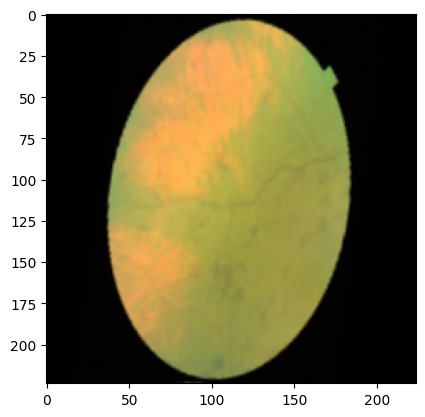

In [9]:
# Augment Images

augmented_images = image_augmentation(images)
augmented_eval_images = image_augmentation(eval_images)
print(augmented_images.shape)
print(augmented_eval_images.shape)

plt.imshow(augmented_images[0])
plt.imshow(augmented_eval_images[0])


when comiling, it's categorical cross entropy instead of binary cross entropy

In [10]:
model = create_model_stage2((224,224,3), last_layer_neurons=num_cols(X_train))


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 774400)            0         
                                                                 
 dense (Dense)               (None, 12)                9292812   
                                                             

In [13]:
early_stopper = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.05,
    patience=10,
)


In [14]:
model.fit(
    augmented_images, y_train,
    validation_data=(augmented_eval_images, y_eval),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopper]
)


Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.7096 - accuracy: 0.3713

ValueError: in user code:

    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/martiandust/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (64, 1) and (64, 5) are incompatible


In [16]:
model.evaluate(augmented_eval_images, y_eval)
